In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_encounters = pd.read_csv('../../data/diabetic_data.csv', 
                            na_values='?',
                            low_memory=False #silence the mixed dtypes warning
                           )
df_encounters.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


<h1> Preprocessing</h1>

<h3> Columns with Null Values </h3>

First, let's examine the number of null values for each feature.

In [4]:
df_encounters.isnull().sum().sort_values(ascending=False).head(10)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
encounter_id             0
dtype: int64

<h4> Weight and Payer Code </h4>

Weight jumps out as a feature with a vast majority of null values, so that feature will be dropped from our analysis.

Payer code, a feature related to the indentity of the health insurance provider (Blue Cross Blue Shield, Medicare, etc.) is also a candidate for droppoing both due to high missingness and lower clinical relevance.

<h4> Max_glu_serum </h4>

Let us now examine the rest of features with NaN values, starting with max_glu_serum. Here, none actually signifies that the glucose was not measured, which is clinically relevant, so we keep this feature.

In [5]:
df_encounters['max_glu_serum'].value_counts()

max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64

We will repalce the nan values with unknown, to signify that the measurements were not taken. For later processing, we will also create a feature signifying whether the glucose serum test result is high, which we will categorize as a reading > 300.

<h5> Function to Process Max Glu Serum </h5>

In [6]:
def process_max_glu_serum(df):
    if 'max_glu_serum' not in df.columns:
        print("Max glu serum is not a feature in the dataframe")
        return None

    df['max_glu_serum_high'] = df['max_glu_serum'].fillna(0).replace({'>300':1, 
                                                                                            'Norm':0,'>200':0})
    
    df['max_glu_serum'] = df['max_glu_serum'].fillna('UNK') #not measured
    
    return df

<h4> A1C Result </h4>

The A1C result is one of the main predictors in the paper describing this dataset. HbA1C is a blood test that measures glycated hemoglobin, with higher values indicating a higher risk for developing diabetes. Chemically, sugar present in the bloodstream reacts with the hemoglobin, forming glycated hemoglobin, and the sugar remains bound for the remainder of the life of the hemoglobin cell, which is several months. Therefore, the A1C level represents a weighted time average of a patients glucose level over the previous several months.

In [7]:
df_encounters['A1Cresult'].value_counts()

A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64

As before, none values are clinically relevant (the measurement was not taken) and we will those none values with UNK. For later processing, we again create a feature signifying whether the measurement is high, which we will categorize as a reading > 8.

<h5> Function to Process A1C Result </h5>

In [8]:
def process_A1Cresult(df):
    if 'A1Cresult' not in df.columns:
        print("A1Cresult is not a feature in the dataframe")
        return None
    
    df['a1c_result_high'] = df['A1Cresult'].fillna(0).replace({'>8':1,'Norm':0,'>7':0})
    
    df['A1Cresult'] = df['A1Cresult'].fillna('UNK')

    return df

<h4> Medical Specialty </h4>

In [9]:
num_spec = len(df_encounters['medical_specialty'].value_counts())
print(f'There are {num_spec} unique specialties')

There are 72 unique specialties


In [10]:
df_encounters['medical_specialty'].value_counts().head(10)

medical_specialty
InternalMedicine              14635
Emergency/Trauma               7565
Family/GeneralPractice         7440
Cardiology                     5352
Surgery-General                3099
Nephrology                     1613
Orthopedics                    1400
Orthopedics-Reconstructive     1233
Radiologist                    1140
Pulmonology                     871
Name: count, dtype: int64

In [11]:
top9_sum = sum(df_encounters['medical_specialty'].value_counts().head(9))
top9_perc = top9_sum/sum(df_encounters['medical_specialty'].value_counts())

print(f'The top 9 specialties account for {top9_sum} encounters and {top9_perc*100:.2f}% of non-NaN encounters')

The top 9 specialties account for 43477 encounters and 83.90% of non-NaN encounters


<Axes: xlabel='age', ylabel='Count'>

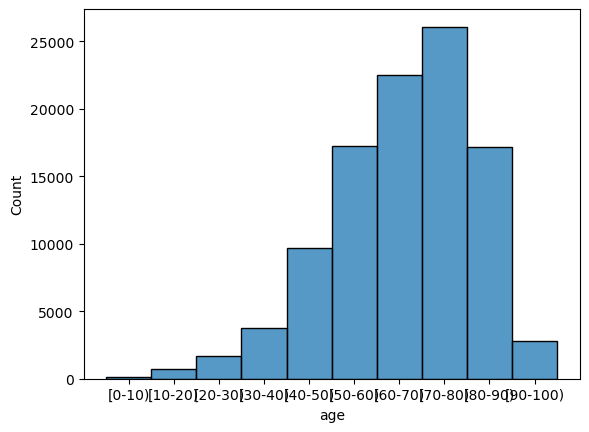

In [12]:
sns.histplot(df_encounters['age'])

In [13]:

df_patient_encounter = df_encounters.groupby('patient_nbr') \
                                    .agg({'encounter_id':'nunique', 
                                          'time_in_hospital':['mean','min','max'],
                                          'num_lab_procedures':['mean','min','max'],
                                          'num_procedures': ['mean','min','max'],
                                          'num_medications':['mean','min','max'],
                                          'number_diagnoses':['mean','min','max'],
                                          #'max_glu_serum':['nunique'],
                                          #'max_glu_serum_high':['mean','sum','all','any'],
                                          'A1Cresult':'nunique',
                                          #'a1c_result_high':['mean','sum','all','any'],
                                          'change':['mean','sum','all','any'],
                                          'diabetesMed': ['mean','sum','all','any'],
                                          'readmitted': ['mean','sum','all','any']})

TypeError: Could not convert ChCh to numeric

In [14]:
df_patient = pd.read_csv('../../data/diabetic_data_processed.csv')

In [15]:
df_patient['A1Cresult'].value_counts()

A1Cresult
UNK     57691
>8       5837
Norm     3716
>7       2746
Name: count, dtype: int64

In [16]:
df_patient['max_glu_serum'].value_counts()

max_glu_serum
UNK     66629
Norm     1743
>200      948
>300      670
Name: count, dtype: int64

In [17]:
df_patient.head()

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,med_always_changed,med_ever_changed,avg_times_diabetic_med_prescribed,num_times_diabetic_med_prescribed,diabetic_med_always_prescribed,diabetic_med_ever_prescribed,avg_times_readmitted,num_times_readmitted,always_readmitted,ever_readmitted
0,135,Caucasian,Female,[50-60),Emergency,Home,Emergency Room,3,UNK,Other,...,1,1,1.0,2,1,1,0.5,1,0,1
1,378,Caucasian,Female,[50-60),Elective,Home,Physician Referral,2,UNK,Other,...,0,0,0.0,0,0,0,0.0,0,0,0
2,729,Caucasian,Female,[80-100),Emergency,SNF,Emergency Room,4,MC,InternalMedicine,...,0,0,1.0,1,1,1,0.0,0,0,0
3,774,Caucasian,Female,[80-100),Emergency,Home,Emergency Room,3,UNK,InternalMedicine,...,1,1,1.0,1,1,1,0.0,0,0,0
4,927,AfricanAmerican,Female,[0-50),Emergency,Home,Emergency Room,5,UNK,InternalMedicine,...,0,0,1.0,1,1,1,0.0,0,0,0


In [18]:
df_patient['medical_specialty'].value_counts()

medical_specialty
Other                     39854
InternalMedicine          10788
Family/GeneralPractice     4894
Emergency/Trauma           4388
Cardiology                 4094
Surgery-General            2220
Orthopedics                2100
Nephrology                  847
Radiologist                 805
Name: count, dtype: int64